# Instance-based metode

**"A family of learning algorithms that, instead of performing explicit generalization, compares new problem instances with instances seen in training"**

# Pregled
* Instance-based metode klasifikacije
* k-nearest neighbours (k-NN)
  * Weighted k-NN
* Lokalno-težinska regresija (LWR)

# Instance-based metode klasifikacije

**Instance-based metode** su metode koje ne grade eksplicitan model podataka (u vidu neke funkcije) koji generalizuje. Umesto toga, klasifikacija se vrši na osnovu skupa instanci za trening, koje se čuvaju i bivaju upotrebljene tek kada je potrebno da se izvrši sama klasifikacija.

# k-nearest neighbours
**k-nearest neighbours** tj. **k-NN** je tehnika koja klasifikuje nepoznate primere na osnovu k najbližih suseda (uglavnom po euklidskoj distanci u prostoru feature-a). Dakle, umesto treninga, nepoznati primer $x$ klasifikujemo u klasu koja se najčešće pojavljuje u najbližih k trening primera. Ovo čini da faza treninga bude nepostojeća, ali da faza predikcije za novi primer bude u nekim slučajevima veoma spora.

U **Weighted k-NN** varijaciji glas svakog od k suseda ne dobija istu težinu tj. uvodimo eksplicitne težine koje su obrnuto proporcionalne udaljenosti (uglavnom 1/d).

Pored načina na koji se dodeljuju težine, jedini parametar modela je **k**. Ovaj parametar predstavlja balans između posmatranja lokalne i globalne strukture: ukoliko koristimo **k=1** model prestaje da bude otporan na šum tj. prisustvo outlier-a. Sa druge strane, povećavanje **k** donosi bolje rezultate do neke granice, nakon čega previše uzimamo u obzir globalna svojstva.

Jedna od čestih primena k-NN modela je u sistemima za preporuku (recommender systems) tj. u metodama kolaborativnog filtriranja (collaborative filtering). Npr. na osnovu skupa podataka koji sadrži ocene velikog broja ljudi za određene filmove, možemo novom korisniku preporučiti film koji bi bio odgovarajući.

U našem slučaju pogledaćemo k-NN u praksi na primeru klasifikacije ručno pisanih cifara ([MNIST](http://yann.lecun.com/exdb/mnist/) skup podataka).

## k-NN za MNIST

60000 10000
[5 0 4 ... 5 6 8]
Test example: 1/100| Predicted: 7| Actual: 7| Match: True
Test example: 11/100| Predicted: 0| Actual: 0| Match: True
Test example: 21/100| Predicted: 9| Actual: 9| Match: True
Test example: 31/100| Predicted: 3| Actual: 3| Match: True
Test example: 41/100| Predicted: 1| Actual: 1| Match: True
Test example: 51/100| Predicted: 6| Actual: 6| Match: True
Test example: 61/100| Predicted: 7| Actual: 7| Match: True
Test example: 71/100| Predicted: 7| Actual: 7| Match: True
Test example: 81/100| Predicted: 7| Actual: 7| Match: True
Test example: 91/100| Predicted: 3| Actual: 3| Match: True
99 matches out of 100 examples
Test set accuracy:  0.99


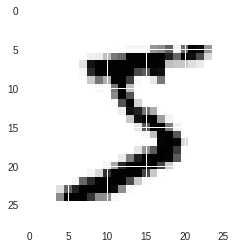

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


class KNN:
  
  def __init__(self, nb_features, nb_classes, data, k, weighted = False):
    self.nb_features = nb_features
    self.nb_classes = nb_classes
    self.data = data
    self.k = k
    self.weight = weighted
    
    # Gradimo model, X je matrica podataka a Q je vektor koji predstavlja upit.
    self.X = tf.placeholder(shape=(None, nb_features), dtype=tf.float32)
    self.Y = tf.placeholder(shape=(None), dtype=tf.int32)
    self.Q = tf.placeholder(shape=(nb_features), dtype=tf.float32)
    
    # Racunamo kvadriranu euklidsku udaljenost i uzimamo minimalnih k.
    dists = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(self.X, self.Q)), 
                                  axis=1))
    _, idxs = tf.nn.top_k(-dists, self.k)  
    
    self.classes = tf.gather(self.Y, idxs)
    self.dists = tf.gather(dists, idxs)
    
    if weighted:
       self.w = 1 / self.dists  # Paziti na deljenje sa nulom.
    else:
       self.w = tf.fill([k], 1/k)
    
    # Svaki red mnozimo svojim glasom i sabiramo glasove po kolonama.
    w_col = tf.reshape(self.w, (k, 1))
    self.classes_one_hot = tf.one_hot(self.classes, nb_classes)
    self.scores = tf.reduce_sum(w_col * self.classes_one_hot, axis=0)
    
    # Klasa sa najvise glasova je hipoteza.
    self.hyp = tf.argmax(self.scores)
  
  # Ako imamo odgovore za upit racunamo i accuracy.
  def predict(self, query_data):
    
    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
     
      # nb_queries = query_data['x'].shape[0]
      
      # Pokretanje na svih 10000 primera bi trajalo predugo,
      # pa pokrecemo samo prvih 100.
      nb_queries = 100
      
      matches = 0
      for i in range(nb_queries):
        hyp_val = sess.run(self.hyp, feed_dict = {self.X: self.data['x'], 
                                                  self.Y: self.data['y'], 
                                                 self.Q: query_data['x'][i]})
        if query_data['y'] is not None:
          actual = query_data['y'][i]
          match = (hyp_val == actual)
          if match:
            matches += 1
          if i % 10 == 0:
            print('Test example: {}/{}| Predicted: {}| Actual: {}| Match: {}'
                 .format(i+1, nb_queries, hyp_val, actual, match))
      
      accuracy = matches / nb_queries
      print('{} matches out of {} examples'.format(matches, nb_queries))
      return accuracy
    

# Ucitavamo MNIST skup podataka.
mnist = tf.keras.datasets.mnist
(train_x, train_y), (test_x, test_y) = mnist.load_data()

nb_train = len(train_y)
nb_test = len(test_y)
print(nb_train, nb_test)
print(train_y)

# Prikazujemo prvu sliku.
plt.imshow(train_x[0], cmap='Greys')  

train_x = np.reshape(train_x, [nb_train, -1])
test_x = np.reshape(test_x, [nb_test, -1])

# Pokrecemo kNN na test skupu.
nb_features = 28 * 28
nb_classes = 10
k = 5
train_data = {'x': train_x, 'y': train_y}
knn = KNN(nb_features, nb_classes, train_data, k, weighted = False)
accuracy = knn.predict({'x': test_x, 'y': test_y})
print('Test set accuracy: ', accuracy)



# Lokalno-težinska regresija (LWR)

**Lokalno-težinska regresija** (Locally-Weighted Regression, LWR) trenira novu (linearnu) regresiju za svaki upit. Pritom, u računanju funkcije troška (MSE) veća težina se daje bližim tačkama iz trening skupa. Formula za težinu je često $w(i) = \exp({-\frac{(x^{(i)} - x)^2}{2\tau^2}})$ (nenormirana normalna raspodela sa $\mu=x$ i $\sigma^2=\tau^2$). LWR dakle aproksimira podatke linearnom funkcijom (kao i standardna linearna regresija) ali se više fokusira na lokalne pravilnosti time što daje prednost bliskim trening primerima.

[Više o LWR](https://see.stanford.edu/materials/aimlcs229/cs229-notes1.pdf)


Epoch: 10/100| Avg loss: 0.00420
Epoch: 20/100| Avg loss: 0.00378
Epoch: 30/100| Avg loss: 0.00371
Epoch: 40/100| Avg loss: 0.00366
Epoch: 50/100| Avg loss: 0.00361
Epoch: 60/100| Avg loss: 0.00356
Epoch: 70/100| Avg loss: 0.00351
Epoch: 80/100| Avg loss: 0.00347
Epoch: 90/100| Avg loss: 0.00343
Epoch: 100/100| Avg loss: 0.00340
w =  [0.501315] bias =  -0.49488777


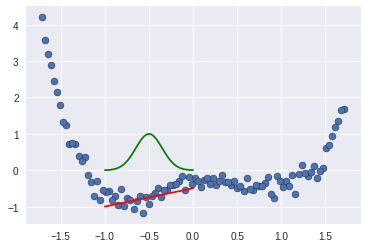

In [9]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np

tf.reset_default_graph()

# Korak 1: Učitavanje i obrada podataka.
filename = 'polynomial.csv'
data = dict()
data['x'], data['y'] = np.loadtxt(filename, delimiter=',', unpack=True)
nb_features = 1

# Nasumično mešanje.
nb_samples = data['x'].shape[0]
indices = np.random.permutation(nb_samples)
data['x'] = data['x'][indices]
data['y'] = data['y'][indices]

# Normalizacija.
data['x'] = (data['x'] - np.mean(data['x'], axis=0)) / np.std(data['x'], axis=0)
data['y'] = (data['y'] - np.mean(data['y'])) / np.std(data['y'])

# Iscrtavanje.
plt.scatter(data['x'], data['y'], edgecolors='k')

# Korak 2: Model.
X = tf.placeholder(shape=(None, nb_features), dtype=tf.float32)
Y = tf.placeholder(shape=(None), dtype=tf.float32)
w = tf.Variable(tf.zeros(nb_features))
bias = tf.Variable(0.0)

w_col = tf.reshape(w, [nb_features, 1])
hyp = tf.add(tf.matmul(X, w_col), bias)

# Korak 3: Funkcija troška i optimizacija.

q = tf.placeholder(shape=(nb_features), dtype=tf.float32)
tau = 0.15

diff_sq = tf.pow(tf.subtract(X, q), 2)
tau_sq = tf.multiply(tf.pow(tau, 2), 2)
loss_w = tf.exp(tf.div(-diff_sq, tau_sq))

Y_col = tf.reshape(Y, (-1, 1))
loss = tf.reduce_mean(tf.multiply(tf.square(Y - hyp), loss_w))
opt_op = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

# Korak 4: Trening.
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  # Izvršavamo 100 epoha treninga za upit -0.5.
  query = -0.5
  nb_epochs = 100
  for epoch in range(nb_epochs):
    epoch_loss = 0
    for sample in range(nb_samples):
      feed = {X: data['x'][sample].reshape((1, nb_features)), 
              Y: data['y'][sample], q: [query]}
      _, curr_loss = sess.run([opt_op, loss], feed_dict=feed)
      epoch_loss += curr_loss
        
    # U svakoj desetoj epohi ispisujemo prosečan loss.
    epoch_loss /= nb_samples
    if (epoch + 1) % 10 == 0:
      print('Epoch: {}/{}| Avg loss: {:.5f}'.format(epoch+1, nb_epochs, 
                                              epoch_loss))
 
  # Ispisujemo finalnu vrednost parametara.
  w_val = sess.run(w)
  bias_val = sess.run(bias)
  print('w = ', w_val, 'bias = ', bias_val)
  
  # Iscrtavamo hipotezu i raspodelu MSE tezina.
  xs = np.linspace(-1.0, 0.0, 50)
  plt.plot(xs, xs * w_val + bias_val, color='r')
  plt.plot(xs, np.exp(-(xs-query) ** 2 / (2 * (tau ** 2))), color='g')